![](pics/header.jpg)

# Calibration with Markers

An ArUco marker is a synthetic square marker composed by a wide black border and a inner binary matrix which determines its identifier (id). The black border facilitates its fast detection in the image and the binary codification allows its identification and the application of error detection and correction techniques. The marker size determines the size of the internal matrix. For instance a marker size of 4x4 is composed by 16 bits.

![](pics/markers.jpg)

![](pics/singlemarkersdetection.png)

The ArUco module can be used to calibrate a camera. Camera calibration consists in obtaining the camera intrinsic parameters and distortion coefficients. Camera calibration is usually performed using the OpenCV `calibrateCamera()` function. This function requires some correspondences between environment points and their projection in the camera image from different viewpoints. In general, these correspondences are obtained from the corners of chessboard patterns. Calibrating using ArUco is much more versatile than using traditional chessboard patterns, since it allows occlusions or partial views.

![](pics/charucodefinition.png)

ChArUco boards combine ArUco markers with a standard checkerboard. ChArUco board corners provide much more accuratacy in comparison to the ArUco marker corners. Calibration using a standard Board should only be employed in those scenarios where the ChArUco boards cannot be employed because of any kind of restriction.

## API

### Dictionary

The markers are generated according to a *dictionary* which defines the number of horizontal and vertical bits for each marker and the total number of valid values that are contained. For example, `aruco.DICT_4X4_50` defines a 4x4 2D marker with 50 unique marker ids in it.

### Boards

The board structure has the following useful members/methods:

- 'chessboardCorners',
- 'create',
- 'dictionary',
- 'draw',
- 'getChessboardSize',
- 'getMarkerLength',
- 'getSquareLength',
- 'ids',
- 'nearestMarkerCorners',
- 'nearestMarkerIdx',
- 'objPoints'

Found markers can be drawn on an image using `aruco.drawDetectedMarkers(img, corners, ids)`.

## References

- [OpenCV 4.0: ArUco Tutorials](https://docs.opencv.org/4.0.0/d9/d6d/tutorial_table_of_content_aruco.html)
- [Automatic generation and detection of highly reliable fiducial markers under occlusion](docs/paper-2014.pdf)
- [Notes using aruco markers](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html)

# Stereo Calibration

1. Let's calibrate each camera individually and find its intrinsic parameters
2. Use this data to then calibrate the two cameras together and find their extrinsic parameters

In [36]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

In [2]:
import cv2.aruco as aruco
from glob import glob
import pickle

In [5]:
def get_images(path, gray=False):
    """
    Given a path, it reads all images. This uses glob to 
    grab file names and excepts wild cards *
    Ex. getImages('./images/*.jpg')
    """
    imgsL = []
    imgsR = []
    files = glob(path)
    files.sort()  # put in order

    print("Found {} images at {}".format(len(tuple(files)), path))
    # print('-'*40)

    for i, f in enumerate(files):
        img = cv2.imread(f)
        if img is None:
            print('>> Could not read: {}'.format(f))
        else:
            h, w = img.shape[:2]

            if gray:
                if len(img.shape) > 2:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            imgsL.append(img[:,:w//2])
            imgsR.append(img[:,w//2:])
    # print('-'*40)
    return imgsL, imgsR

Found 19 images at aruco-imgs/*.png


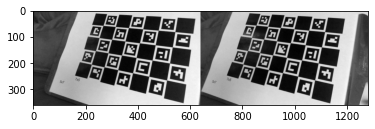

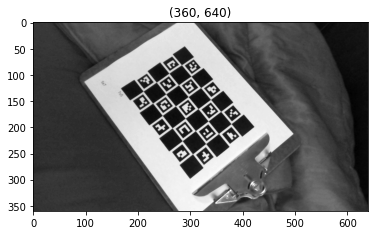

In [6]:
# the left/right images are stored together as one image. We
# need to read in each image and cut it in half to separate out
# the left/right
imgsL, imgsR = get_images("aruco-imgs/*.png", gray=True)
plt.figure()
plt.imshow(np.hstack((imgsL[0],imgsR[0])), cmap='gray');

plt.figure()
plt.imshow(imgsL[-1], cmap='gray')
plt.title('{}'.format(imgsL[0].shape));

In [10]:
class Calibrate(object):
    """Calibrate an individual camera"""
    def __init__(self):
        self.dictionary = aruco.Dictionary_get(aruco.DICT_4X4_50)
        parameters = aruco.DetectorParameters_create()
        x = 5  # horizontal
        y = 7  # vertical
        sqr = 0.254  # solid black squares
        mrk = 0.23 # markers, must be smaller than squares
        self.board = aruco.CharucoBoard_create(
            x,y,
            sqr,
            mrk,
            self.dictionary)
        
    def calculateReprojectionError(self, imgpoints, objpoints, rvecs, tvecs, mtx, dist):
        """
        imgpts: features found in image, (num_imgs, 2)
        objpts: calibration known features in 3d, (num_imgs, 3)
        """
        imgpoints = [c.reshape(-1,2) for c in imgpoints]
        mean_error = 0
        for i in range(len(objpoints)):
#             print('img',imgpoints[i].shape)
#             print('obj', objpoints[i].shape)
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
            imgpoints2 = imgpoints2.reshape(-1,2)
#             print('img2', imgpoints2.shape)
            
            # if not all markers were found, then the norm below will fail
            if len(imgpoints[i]) != len(imgpoints2):
                continue
                
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
            mean_error += error
        print( "total error: {}".format(mean_error/len(objpoints)) )
        
    def calibrate(self, imgs, K=None):
        calcorners = []  # 2d points in image
        calids = []  # ids found in image
        h,w = imgs[0].shape[:2]
        
        # so we know a little bit about the camera, so
        # start off the algorithm with a simple guess
        f = max(h,w)  # focal length is a function of image size in pixels
        K = np.array([
            [f,0,w/2],
            [0,f,h/2],
            [0.,0.,1.]
        ])

        for im in imgs:
            # make grayscale if it is not already
            if len(im.shape) > 2:
                gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            else:
                gray = im.copy()
                
            corners, ids, rejectedImgPts = aruco.detectMarkers(gray, self.dictionary)
#             print("detectMarkers found {} corners {} ids".format(
#                 len(corners), len(ids)))
            
            # if ids were found, then
            if ids is not None and len(ids) > 0:
                ret, chcorners, chids = aruco.interpolateCornersCharuco(
                    corners, ids, gray, self.board)
#                 print("interpolateCornersCharuco[{}] found {} corners {} ids".format(
#                     ret, len(chcorners), len(chids)))
                calcorners.append(chcorners)
                calids.append(chids)

#                 if len(im.shape) > 2:
#                     im2 = im.copy()
#                 else:
#                     im2 = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
                    
#                 aruco.drawDetectedCornersCharuco(im2, chcorners, chids)
#                 aruco.drawDetectedMarkers(im2, corners, ids=ids, borderColor=(100, 0, 240))

#                 plt.figure(figsize=(10,5))
#                 plt.imshow(im2)

        flags = 0
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS  # make an inital guess at cameraMatrix (K)
#         flags |= cv2.CALIB_FIX_PRINCIPAL_POINT  # value? makes it worse
        rms, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
            calcorners, calids, self.board, (w,h), K, None, flags=flags)
        
        cam_params = {
            'marker_type': 'aruco',
            'cameraMatrix': cameraMatrix,
            'distCoeffs': distCoeffs,
            'image_size': imgs[0].shape[:2],
#             'marker_size': (x,y),
#             'marker_scale:': sqr
            'rms': rms
        }
#         objpts = [self.board.chessboardCorners.copy() for c in calcorners]
        h, w = self.board.chessboardCorners.shape
        objpts = [self.board.chessboardCorners.reshape((h,1,3)) for c in calcorners]
#         imgpts = [c.reshape(-1,2) for c in calcorners]
        imgpts = calcorners
        
        print('obj', len(objpts))
        print('imgpts', len(imgpts))
        
        self.calculateReprojectionError(imgpts, objpts, rvecs, tvecs, cameraMatrix, distCoeffs)
        
        return (rms, cameraMatrix, distCoeffs, rvecs, tvecs, objpts, imgpts)

# Camera Calibrateion (Left/Right): Intrinsics

In [11]:
# left camera parameters
cal = Calibrate()
rms1, M1, d1, r1, t1, objpoints, imgpoints_l = cal.calibrate(imgsL)
print(len(objpoints), objpoints[0].shape, len(imgpoints_l), imgpoints_l[0].shape)

obj 19
imgpts 19
total error: 0.03068915039808545
19 (24, 1, 3) 19 (24, 1, 2)


RMS: 0.19430743172060969 px
Camera Matrix: [[537.81695495   0.         323.09372246]
 [  0.         537.696675   172.7261875 ]
 [  0.           0.           1.        ]]
Dist Coeffs: [[ 1.29076498e-01 -6.41266612e-01 -2.43582358e-03  2.42353835e-04
   9.67365748e-01]]


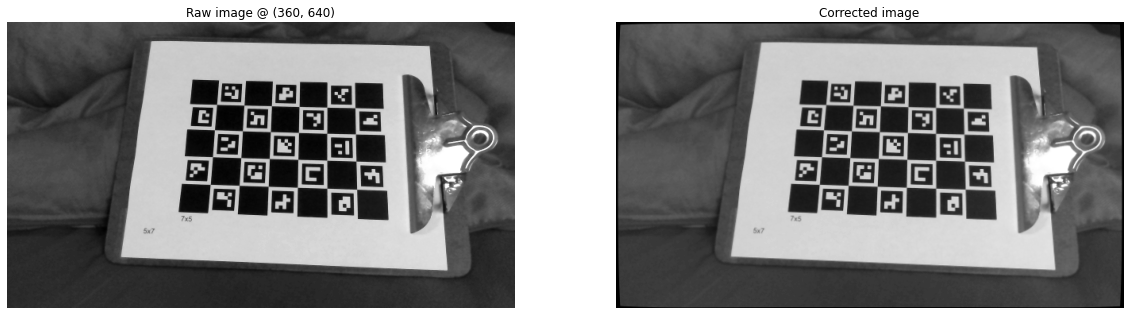

In [12]:
print('RMS:', rms1, 'px')
print('Camera Matrix:', M1)
print('Dist Coeffs:', d1)

i=5 # select image id
plt.figure(figsize=(20,10))
img_undist = cv2.undistort(imgsL[i],M1,d1,None)
plt.subplot(1,2,1)
plt.imshow(imgsL[i], cmap='gray')
plt.title("Raw image @ {}".format(imgsL[i].shape))
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist, cmap='gray')
plt.title("Corrected image")
plt.axis("off");

In [14]:
# right camera parameters
rms2, M2, d2, r2, t2, objpoints, imgpoints_r = cal.calibrate(imgsR)

obj 19
imgpts 19
total error: 0.03025187718618114


RMS: 0.1955380656026334 px
Camera Matrix: [[543.    0.  325.3]
 [  0.  542.4 172.6]
 [  0.    0.    1. ]]
Dist Coeffs: [[ 0.1 -0.2  0.  -0.  -0.2]]


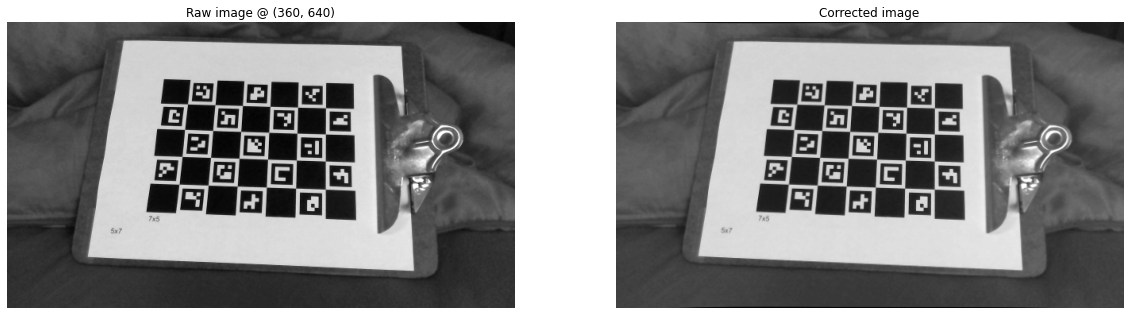

In [42]:
print('RMS:', rms2, 'px')
print('Camera Matrix:', M2)
print('Dist Coeffs:', d2)

i=5 # select image id
plt.figure(figsize=(20,10))
img_undist = cv2.undistort(imgsR[i],M2,d2,None)
plt.subplot(1,2,1)
plt.imshow(imgsR[i], cmap='gray')
plt.title("Raw image @ {}".format(imgsR[i].shape))
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist, cmap='gray')
plt.title("Corrected image")
plt.axis("off");

# Stereo Calibration: Extrinsics

In [41]:
objpts = []
rpts = []
lpts = []
for o,l,r in zip(objpoints,imgpoints_l,imgpoints_r):
    # must have all the same number of points for calibration
    if o.shape[:2] == l.shape[:2] == r.shape[:2]:
        objpts.append(o)
        rpts.append(r)
        lpts.append(l)
    else:
        print("bad points:", o.shape, l.shape, r.shape)

bad points: (24, 1, 3) (12, 1, 2) (16, 1, 2)
bad points: (24, 1, 3) (16, 1, 2) (12, 1, 2)
bad points: (24, 1, 3) (12, 1, 2) (11, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (22, 1, 2)


In [39]:
print('obj pts', len(objpts))
print('imgpoints left', len(lpts))
print('imgpoints right', len(rpts))

flags = 0
# flags |= cv2.CALIB_FIX_INTRINSIC
# flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
flags |= cv2.CALIB_USE_INTRINSIC_GUESS
flags |= cv2.CALIB_FIX_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_ASPECT_RATIO
# flags |= cv2.CALIB_ZERO_TANGENT_DIST
# flags |= cv2.CALIB_RATIONAL_MODEL
# flags |= cv2.CALIB_SAME_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_K3
# flags |= cv2.CALIB_FIX_K4
# flags |= cv2.CALIB_FIX_K5

stereocalib_criteria = (
    cv2.TERM_CRITERIA_MAX_ITER +
    cv2.TERM_CRITERIA_EPS, 
    100, 
    1e-5)

h, w = imgsL[0].shape[:2]

ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
    objpts,
    lpts,
    rpts,
    M1, d1,
    M2, d2,
    (w,h),
    criteria=stereocalib_criteria,
    flags=flags)

print('-'*50)
# print('Image: {}x{}'.format(*imgs_l[0].shape[:2]))
# print('{}: {}'.format(marker_type, marker_size))
print('Intrinsic Camera Parameters')
print('-'*50)
print(' [Camera 1]')
# print('  cameraMatrix_1', M1)
print('  f(x,y): {:.1f} {:.1f} px'.format(M1[0,0], M1[1,1]))
print('  principlePoint(x,y): {:.1f} {:.1f} px'.format(M1[0,2], M1[1,2]))
print('  distCoeffs', d1[0])
print(' [Camera 2]')
# print('  cameraMatrix_2', M2)
print('  f(x,y): {:.1f} {:.1f} px'.format(M2[0,0], M2[1,1]))
print('  principlePoint(x,y): {:.1f} {:.1f} px'.format(M2[0,2], M2[1,2]))
print('  distCoeffs', d2[0])
print('-'*50)
print('Extrinsic Camera Parameters')
print('-'*50)
print('  R\n', R)
print('  T[meter]', T.T)
print('  E\n', E)
print('  F\n', F)

obj pts 15
imgpoints left 15
imgpoints right 15
--------------------------------------------------
Intrinsic Camera Parameters
--------------------------------------------------
 [Camera 1]
  f(x,y): 537.8 537.7 px
  principlePoint(x,y): 325.1 172.5 px
  distCoeffs [ 0.2 -1.2 -0.   0.   2.3]
 [Camera 2]
  f(x,y): 543.0 542.4 px
  principlePoint(x,y): 325.3 172.6 px
  distCoeffs [ 0.1 -0.2  0.  -0.  -0.2]
--------------------------------------------------
Extrinsic Camera Parameters
--------------------------------------------------
  R
 [[ 1. -0.  0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]]
  T[meter] [[-0.3 -0.   0. ]]
  E
 [[-0.  -0.  -0. ]
 [ 0.  -0.   0.3]
 [ 0.  -0.3 -0. ]]
  F
 [[-0.  -0.   0. ]
 [ 0.  -0.   0.8]
 [-0.  -0.8  1. ]]


In [40]:
print('Object Points in 3D [meters]')
print('images:',len(objpoints))
print('features found per image:',objpoints[0].shape)
print('point:',objpoints[0][0])

Object Points in 3D [meters]
images: 19
features found per image: (24, 1, 3)
point: [[0.3 0.3 0. ]]


In [183]:
print('Image Points in 2D [pixels]')
print('images:',len(imgpoints_l))
print('features found per image:',imgpoints_l[0].shape)
print('point:',imgpoints_l[0][0])

Image Points in 2D [pixels]
images: 19
features found per image: (24, 1, 2)
point: [[511.51172 266.49704]]


In [184]:
print('Image Points in 2D [pixels]')
print('images:',len(imgpoints_r))
print('features found per image:',imgpoints_r[0].shape)
print('point:',imgpoints_r[0][0])

Image Points in 2D [pixels]
images: 19
features found per image: (24, 1, 2)
point: [[437.19678 266.40588]]
